# 1. XGBoost - Extreme Gradient Boosting
- Gradient Boost 가 병렬 학습이 지원되도록 구현한 라이브 러리
- Regression, Classification 문제를 모두 지원하며, 성능과 자원 효율이 좋아서, 인기 있게 사용되는 알고리즘

  - Boosting : 여러 개의 성능이 높지 않은 모델을 조합해서 사용하는 앙상블 기법, 성능이 낮은 예측 모형들의 학습 에러에 가중치를 두고, 순차적으로 다음 학습 모델에 반영하여 강한 예측 모형을 만듬

- XGBoost의 장점
   1. 기존 boosting 모델 대비 빠른 수행시간 (병렬 처리)
   2. 분류와 회귀 task에서 높은 예측 성능
   3. Early Stopping(조기 종료) 기능 제공
   4. 다양한 옵션을 제공해 Custimizing이 용이
   5. 결측치를 내부적으로 처리함
   

- XGBoost의 하이퍼 파라미터
   - n_estimators : 학습 모델의 수, 많아질수록 성능 향상의 가능성이 있으나, 속도가 느려짐
   - learning_rate : 학습률, 너무 크면 gradient 발산의 가능성이 있으며, 너무 작으면 학습이 느림
   - max_depth : 최대 탐색 깊이, 너무 크면 과적합의 가능성, 너무 작으면 학습 성능 저하
   - min_samples_split : 분할 종료 최소 샘플 수, 큰 수면 과적합을 막지만 학습 성능 저하 가능성
   - min_samples_leaf : leaf node가 되기 위한 최소 샘플 수, min_samples_split과 비슷한 용도
   - random_state : 특정 숫자로 고정 시에 실행 시마다 고정된 결과 반환 

### XGBoost 실습

In [24]:
! pip install xgboost
# xgboost 설치

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
# 라이브러리 불러오기

In [3]:
import xgboost as xgb
from xgboost import plot_importance

In [4]:
dataset = load_breast_cancer()
# 데이터 로드

X = dataset.data
y = dataset.target

cancer_df = pd.DataFrame(data=X, columns= dataset.feature_names)
cancer_df['target'] = y

In [5]:
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [6]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)

In [8]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# 학습과 예측 데이터 세트를 DMatrix로 변환 필요

In [9]:
params = { 'max_depth' : 3,
          'eta' : 0.1,
          'objective' : 'binary:logistic', # 예측 결정 함수 : 이진 분류
          'early_stoppings' : 100
          }
num_rounds = 400

In [10]:
wlist = [(dtrain,'train'),(dtest,'eval')]
# 데이터를 학습용은 'train', 검증용은 'eval'로 표시

xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)
xgb_model

[13:20:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stoppings" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.60944	eval-logloss:0.61010
[1]	train-logloss:0.54047	eval-logloss:0.54074
[2]	train-logloss:0.48211	eval-logloss:0.48490
[3]	train-logloss:0.43365	eval-logloss:0.43922
[4]	train-logloss:0.39072	eval-logloss:0.39791
[5]	train-logloss:0.35372	eval-logloss:0.36211
[6]	train-logloss:0.32223	eval-logloss:0.32996
[7]	train-logloss:0.29292	eval-logloss:0.30179
[8]	train-logloss:0.26731	eval-logloss:0.27801
[9]	train-logloss:0.24409	eval-logloss:0.25775
[10]	train-logloss:0.22517	eval-logloss:0.24037
[11]	train-logloss:0.20807	eval-logloss:0.22271
[12]	train

In [11]:
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10],3))

[1.    1.    0.    0.997 0.    0.991 0.998 0.999 0.981 0.847]


In [12]:
preds = [1 if x> 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

예측값 10개만 표시: [1, 1, 0, 1, 0, 1, 1, 1, 1, 1]


In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba = None) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    
    print('정확도:{0:.4f}, 정밀도 :{1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}'. format(accuracy, precision, recall, f1, roc_auc),'\n') 

In [14]:
get_clf_eval(y_test,preds,pred_probs)

오차행렬
[[39  2]
 [ 1 72]]
정확도:0.9737, 정밀도 :0.9730, 재현율 : 0.9863, F1 : 0.9796, AUC : 0.9916 



In [16]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate=0.1, max_depth=3)

evals =[(X_test,y_test)]

xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=100, eval_metric="logloss",
                eval_set=evals, verbose=True)

ws1000_preds = xgb_wrapper.predict(X_test)
ws1000_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61010
[1]	validation_0-logloss:0.54074
[2]	validation_0-logloss:0.48490
[3]	validation_0-logloss:0.43922
[4]	validation_0-logloss:0.39791
[5]	validation_0-logloss:0.36211
[6]	validation_0-logloss:0.32996
[7]	validation_0-logloss:0.30179
[8]	validation_0-logloss:0.27801
[9]	validation_0-logloss:0.25775
[10]	validation_0-logloss:0.24037
[11]	validation_0-logloss:0.22271
[12]	validation_0-logloss:0.20795
[13]	validation_0-logloss:0.19531
[14]	validation_0-logloss:0.18460
[15]	validation_0-logloss:0.17183
[16]	validation_0-logloss:0.16152
[17]	validation_0-logloss:0.15443
[18]	validation_0-logloss:0.14913
[19]	validation_0-logloss:0.14175
[20]	validation_0-logloss:0.13378
[21]	validation_0-logloss:0.12809
[22]	validation_0-logloss:0.12310
[23]	validation_0-logloss:0.11735
[24]	validation_0-logloss:0.11254
[25]	validation_0-logloss:0.11103
[26]	validation_0-logloss:0.10784
[27]	validation_0-logloss:0.10638
[28]	validation_0-logloss:0.10329
[29]	validation_0-loglos

c:\Users\A\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\A\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-logloss:0.08311
[39]	validation_0-logloss:0.08118
[40]	validation_0-logloss:0.07966
[41]	validation_0-logloss:0.07900
[42]	validation_0-logloss:0.07876
[43]	validation_0-logloss:0.07849
[44]	validation_0-logloss:0.07727
[45]	validation_0-logloss:0.07715
[46]	validation_0-logloss:0.07628
[47]	validation_0-logloss:0.07591
[48]	validation_0-logloss:0.07610
[49]	validation_0-logloss:0.07658
[50]	validation_0-logloss:0.07621
[51]	validation_0-logloss:0.07556
[52]	validation_0-logloss:0.07539
[53]	validation_0-logloss:0.07570
[54]	validation_0-logloss:0.07568
[55]	validation_0-logloss:0.07537
[56]	validation_0-logloss:0.07557
[57]	validation_0-logloss:0.07528
[58]	validation_0-logloss:0.07551
[59]	validation_0-logloss:0.07561
[60]	validation_0-logloss:0.07556
[61]	validation_0-logloss:0.07534
[62]	validation_0-logloss:0.07603
[63]	validation_0-logloss:0.07596
[64]	validation_0-logloss:0.07646
[65]	validation_0-logloss:0.07728
[66]	validation_0-logloss:0.07730
[67]	validatio

In [18]:
get_clf_eval(y_test, ws1000_preds, ws1000_preds_proba)

오차행렬
[[40  1]
 [ 1 72]]
정확도:0.9825, 정밀도 :0.9863, 재현율 : 0.9863, F1 : 0.9863, AUC : 0.9933 



In [19]:
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=10, eval_metric="logloss",
                eval_set=evals, verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test,ws10_preds,ws1000_preds_proba)

[0]	validation_0-logloss:0.61010
[1]	validation_0-logloss:0.54074
[2]	validation_0-logloss:0.48490
[3]	validation_0-logloss:0.43922
[4]	validation_0-logloss:0.39791
[5]	validation_0-logloss:0.36211
[6]	validation_0-logloss:0.32996
[7]	validation_0-logloss:0.30179
[8]	validation_0-logloss:0.27801
[9]	validation_0-logloss:0.25775
[10]	validation_0-logloss:0.24037
[11]	validation_0-logloss:0.22271
[12]	validation_0-logloss:0.20795
[13]	validation_0-logloss:0.19531
[14]	validation_0-logloss:0.18460
[15]	validation_0-logloss:0.17183
[16]	validation_0-logloss:0.16152
[17]	validation_0-logloss:0.15443
[18]	validation_0-logloss:0.14913
[19]	validation_0-logloss:0.14175
[20]	validation_0-logloss:0.13378
[21]	validation_0-logloss:0.12809
[22]	validation_0-logloss:0.12310
[23]	validation_0-logloss:0.11735
[24]	validation_0-logloss:0.11254
[25]	validation_0-logloss:0.11103
[26]	validation_0-logloss:0.10784
[27]	validation_0-logloss:0.10638
[28]	validation_0-logloss:0.10329
[29]	validation_0-loglos

c:\Users\A\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\A\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-logloss:0.07658
[50]	validation_0-logloss:0.07621
[51]	validation_0-logloss:0.07556
[52]	validation_0-logloss:0.07539
[53]	validation_0-logloss:0.07570
[54]	validation_0-logloss:0.07568
[55]	validation_0-logloss:0.07537
[56]	validation_0-logloss:0.07557
[57]	validation_0-logloss:0.07528
[58]	validation_0-logloss:0.07551
[59]	validation_0-logloss:0.07561
[60]	validation_0-logloss:0.07556
[61]	validation_0-logloss:0.07534
[62]	validation_0-logloss:0.07603
[63]	validation_0-logloss:0.07596
[64]	validation_0-logloss:0.07646
[65]	validation_0-logloss:0.07728
[66]	validation_0-logloss:0.07730
오차행렬
[[40  1]
 [ 1 72]]
정확도:0.9825, 정밀도 :0.9863, 재현율 : 0.9863, F1 : 0.9863, AUC : 0.9933 



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

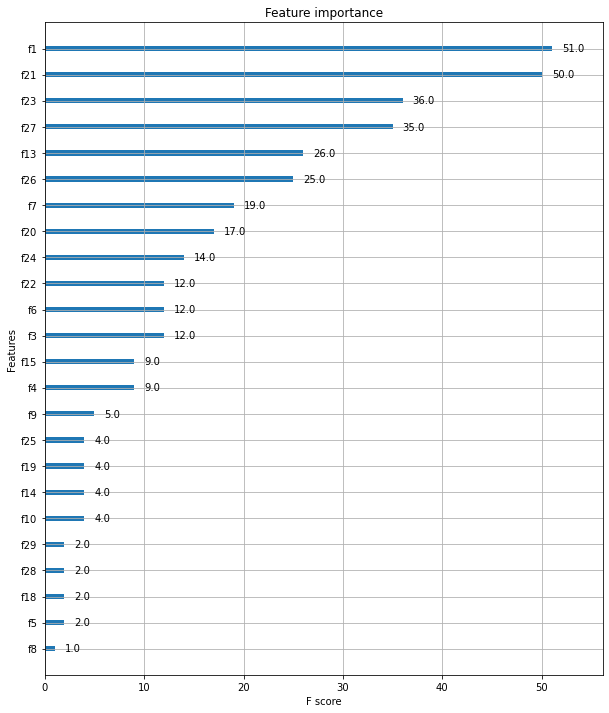

In [21]:
from xgboost import plot_importance
import matplotlib.pyplot as plt 
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))

plot_importance(xgb_wrapper,ax=ax)